In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-closed-questions-on-stack-overflow/basic_benchmark.csv
/kaggle/input/predict-closed-questions-on-stack-overflow/private leaderboard raw.7z
/kaggle/input/predict-closed-questions-on-stack-overflow/train-sample_October_9_2012_v2.csv
/kaggle/input/predict-closed-questions-on-stack-overflow/public_leaderboard.zip
/kaggle/input/predict-closed-questions-on-stack-overflow/prior_benchmark.csv
/kaggle/input/predict-closed-questions-on-stack-overflow/train.zip
/kaggle/input/predict-closed-questions-on-stack-overflow/private_leaderboard.csv
/kaggle/input/predict-closed-questions-on-stack-overflow/train-sample.zip
/kaggle/input/predict-closed-questions-on-stack-overflow/train-sample.gz
/kaggle/input/predict-closed-questions-on-stack-overflow/train_October_9_2012.csv
/kaggle/input/predict-closed-questions-on-stack-overflow/private_leaderboard.7z
/kaggle/input/predict-closed-questions-on-stack-overflow/train-sample_October_9_2012_v2.7z
/kaggle/input/predict-closed-questions-on-

Importing libraries

In [3]:
# Basic imports
 
import torch 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

### Load dataset

In [4]:
# import the data 
data = pd.read_csv("../input/predict-closed-questions-on-stack-overflow/train-sample.csv")
data.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140272 entries, 0 to 140271
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   PostId                               140272 non-null  int64 
 1   PostCreationDate                     140272 non-null  object
 2   OwnerUserId                          140272 non-null  int64 
 3   OwnerCreationDate                    140272 non-null  object
 4   ReputationAtPostCreation             140272 non-null  int64 
 5   OwnerUndeletedAnswerCountAtPostTime  140272 non-null  int64 
 6   Title                                140272 non-null  object
 7   BodyMarkdown                         140272 non-null  object
 8   Tag1                                 140262 non-null  object
 9   Tag2                                 113021 non-null  object
 10  Tag3                                 75914 non-null   object
 11  Tag4                      

## Exploratory Data Analysis

### PostID
##### This feature is the id of the query posted by the user. This feauture does not have any importance in making the prediction but it will be used later for submission we will save it.

In [6]:
data_id=data.PostId

### PostCreationDate
##### The post creation date is the date and time on which the query was posted by the user let us see if we could make something out of this.

##### As we have observed that it doesn't matter on the time the question is posted on its label thus we can just remove this column both from our train and test.

In [7]:
data.drop(['PostCreationDate'],axis=1,inplace=True)

### OwnerUserId
##### This is the user id who posted the query. Let us check it

In [8]:
data['PostCount']=[1]*len(data['PostId'])

In [9]:
pd.pivot_table(data,index='OwnerUserId',columns='OpenStatus',values='PostCount',aggfunc='sum')

OpenStatus,not a real question,not constructive,off topic,open,too localized
OwnerUserId,,,,,
3,NaN,NaN,NaN,1.0,NaN
4,1.0,NaN,NaN,NaN,NaN
5,NaN,NaN,1.0,3.0,NaN
9,NaN,NaN,NaN,2.0,NaN
13,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...
1566931,1.0,NaN,NaN,NaN,NaN
1567000,NaN,NaN,NaN,1.0,NaN
1567022,NaN,NaN,1.0,NaN,NaN


In [10]:
data.loc[data['OpenStatus']=='open','OwnerUserId'].value_counts()

39677      35
34537      32
325418     29
4653       26
117700     23
           ..
693090      1
702813      1
549893      1
537031      1
1539253     1
Name: OwnerUserId, Length: 51314, dtype: int64

We see that it does not matter on the OwnerUserId whether his question is going to be open or not as there are many user whose only one question remain open So, we would be dropping this column

In [11]:
data.drop(['OwnerUserId'],axis=1,inplace=True)

### Reputation at Post Created
##### This can be a important factor. Let's take a look at it

In [12]:
data['ReputationAtPostCreation'].min()


-34

In [13]:
data['ReputationAtPostCreation'].max()


209631

In [14]:
#Since the data range is such high let us scale it using MinMaxScaler
minimum=data['ReputationAtPostCreation'].min()
maximum=data['ReputationAtPostCreation'].max()
data['ReputationAtPostCreation']=(data['ReputationAtPostCreation']-minimum)/(maximum-minimum)

### OwnerUndeletedAnswerCountAtPostTime

In [15]:
data.OwnerUndeletedAnswerCountAtPostTime.value_counts()

0       65066
1       13132
2        7526
3        5294
4        4037
        ...  
1565        1
2182        1
980         1
1320        1
943         1
Name: OwnerUndeletedAnswerCountAtPostTime, Length: 965, dtype: int64

This feature doesnot seem to be doing anything, we will be dropping it for now.


In [16]:
data.drop(['OwnerUndeletedAnswerCountAtPostTime'],axis=1,inplace=True)

### PostClosedDate¶
##### Dropping this column as post closed date does not seem to be doing anything, so we would be dropping it

In [17]:
data.drop(['PostClosedDate'],axis=1,inplace=True)

### tag1

In [18]:
data['Tag1'].isnull().sum()

10

We can combine all the tags column into one this would help us in comparing the words which are used as tags and the words used in Title and Body.

In [19]:
data['Tag1']=data['Tag1'].replace(np.nan,' ')
data['Tag2']=data['Tag2'].replace(np.nan,' ')
data['Tag3']=data['Tag3'].replace(np.nan,' ')
data['Tag4']=data['Tag4'].replace(np.nan,' ')
data['Tag5']=data['Tag5'].replace(np.nan,' ')

In [20]:
#combine all tags to make a new column
data['Tags']=data['Tag1']+' '+data['Tag2']+' '+data['Tag3']+' '+data['Tag4']+' '+data['Tag5']

In [21]:
data['Tags']

0                                           mongodb        
1                                          dom xsd jaxp    
2                      sql-server database-design enums    
3                                          php vb.net      
4                                 mongodb spring-data      
                                ...                        
140267    bitwise-operators discrete-mathematics compile...
140268                   mysql ruby-on-rails gem osx-lion  
140269                                      asp.net        
140270                              html copy remove move  
140271                  php content-management-system      
Name: Tags, Length: 140272, dtype: object

In [22]:
#change to lowercase
data['Tags']=data['Tags'].str.lower()

In [23]:
#remove white spaces in left and right places
data['Tags']=data['Tags'].apply(lambda x:x.lstrip())
data['Tags']=data['Tags'].apply(lambda x:x.rstrip())

In [24]:
data.head()

,PostId,OwnerCreationDate,ReputationAtPostCreation,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,OpenStatus,PostCount,Tags
0,6046168,09/17/2010 10:15:06,0.000167,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,,,,,open,1,mongodb
1,4873911,10/03/2010 09:30:58,0.001078,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,,,open,1,dom xsd jaxp
2,3311559,07/22/2010 16:58:20,0.000167,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,,,open,1,sql-server database-design enums
3,9990413,07/19/2011 10:22:40,0.000181,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,,,,too localized,1,php vb.net
4,10421966,02/04/2011 18:05:34,0.001755,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,,,,open,1,mongodb spring-data


In [25]:
# Dropping excess columns 
data.drop(['PostId','OwnerCreationDate','Tag1','Tag2','Tag3','Tag4','Tag5','PostCount'],axis=1,inplace=True)

In [26]:
data.head()

,ReputationAtPostCreation,Title,BodyMarkdown,OpenStatus,Tags
0,0.000167,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,open,mongodb
1,0.001078,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,open,dom xsd jaxp
2,0.000167,Too many lookup tables,What are the adverse effects of having too man...,open,sql-server database-design enums
3,0.000181,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,too localized,php vb.net
4,0.001755,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",open,mongodb spring-data


In [27]:
data.drop(['ReputationAtPostCreation'],axis=1,inplace=True)

### Feature selection

In [28]:
# Let's take 'TITLE' & 'BODYMARKDOWN' & OpenStatus Columns 
data_train = data[['Title', 'BodyMarkdown','Tags', 'OpenStatus']]
data_train.head()

,Title,BodyMarkdown,Tags,OpenStatus
0,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,open
1,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom xsd jaxp,open
2,Too many lookup tables,What are the adverse effects of having too man...,sql-server database-design enums,open
3,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php vb.net,too localized
4,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb spring-data,open


In [29]:
data_train.shape

(140272, 4)

In [30]:
# Sample 80k randomly! 
data_train = data_train.sample(80000, random_state = 234)
data_train.head()

,Title,BodyMarkdown,Tags,OpenStatus
122715,How to serialize Color property as ARGB values?,I'm working with Windows Forms designer. It se...,winforms windows-form-designer colors rgb seri...,open
29350,Sending large files in java,How to send large files (2-3 GB) over the netw...,networking,not a real question
6938,How to Create personal online radio station?,"I want to create my own radio station, that is...",asp.net,off topic
131897,how to name my android software legally?,Im new to android programming and i found a pr...,android android-market google-play,off topic
10420,Broke Emacs 24 on Lion 10.7.4,I just managed to break my beloved Emacs on Li...,emacs osx-lion macports ncurses,off topic


In [31]:
# Fill NaN values with empty strings
data_train = data_train.fillna('')

# Display the updated dataset
data_train.head()

,Title,BodyMarkdown,Tags,OpenStatus
122715,How to serialize Color property as ARGB values?,I'm working with Windows Forms designer. It se...,winforms windows-form-designer colors rgb seri...,open
29350,Sending large files in java,How to send large files (2-3 GB) over the netw...,networking,not a real question
6938,How to Create personal online radio station?,"I want to create my own radio station, that is...",asp.net,off topic
131897,how to name my android software legally?,Im new to android programming and i found a pr...,android android-market google-play,off topic
10420,Broke Emacs 24 on Lion 10.7.4,I just managed to break my beloved Emacs on Li...,emacs osx-lion macports ncurses,off topic


In [32]:
data_train.isna().sum()

Title           0
BodyMarkdown    0
Tags            0
OpenStatus      0
dtype: int64

### Preprocessing

In [33]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required resources (only need to do this once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define the preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = remove_html_tags(text)
    
    #Remove URL tags
    text = remove_urls(text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the words
    #lemmatizer = WordNetLemmatizer()
    #tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Function to remove HTML tags
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

# Function to remove URL links
def remove_urls(text):
    pattern = re.compile(r'http\S+|www\S+')
    return pattern.sub(r'', text)

# Apply preprocessing to the 'Title' and 'BodyMarkdown' columns
data_train['Title'] = data_train['Title'].apply(preprocess_text)
data_train['BodyMarkdown'] = data_train['BodyMarkdown'].apply(preprocess_text)
data_train['Tags'] = data_train['Tags'].apply(preprocess_text)

# Display the preprocessed dataset
print(data_train.head())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
                                       Title  \
122715  serialize color property argb values   
29350               sending large files java   
6938    create personal online radio station   
131897         name android software legally   
10420                       broke emacs lion   

                                             BodyMarkdown  \
122715  working windows forms designer serializes prop...   
29350   send large files gb network using sockets writ...   
6938    want create radio station host application e g...   
131897  im new android programming found pretty name a...   
10420   managed break beloved emacs lion hope 

In [34]:
#Lets see the the data!
data_train.head()

,Title,BodyMarkdown,Tags,OpenStatus
122715,serialize color property argb values,working windows forms designer serializes prop...,winforms windows form designer colors rgb seri...,open
29350,sending large files java,send large files gb network using sockets writ...,networking,not a real question
6938,create personal online radio station,want create radio station host application e g...,asp net,off topic
131897,name android software legally,im new android programming found pretty name a...,android android market google play,off topic
10420,broke emacs lion,managed break beloved emacs lion hope time eff...,emacs osx lion macports ncurses,off topic


In [35]:
data_train.OpenStatus.unique()

array(['open', 'not a real question', 'off topic', 'not constructive',
       'too localized'], dtype=object)

In [36]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the 'OpenStatus' column
encoder.fit(data_train['OpenStatus'])

# Encode the 'OpenStatus' column
data_train['OpenStatus'] = encoder.transform(data_train['OpenStatus'])

In [37]:
list(encoder.classes_)

['not a real question',
 'not constructive',
 'off topic',
 'open',
 'too localized']

In [38]:
#change the unique elements in openstatus column to 
#data_train['OpenStatus']= data_train['OpenStatus'].map({'open': 0, 'not a real question': 1, 'off topic': 2, 'not constructive': 3, 'too localized': 4}) 
data_train.head()

,Title,BodyMarkdown,Tags,OpenStatus
122715,serialize color property argb values,working windows forms designer serializes prop...,winforms windows form designer colors rgb seri...,3
29350,sending large files java,send large files gb network using sockets writ...,networking,0
6938,create personal online radio station,want create radio station host application e g...,asp net,2
131897,name android software legally,im new android programming found pretty name a...,android android market google play,2
10420,broke emacs lion,managed break beloved emacs lion hope time eff...,emacs osx lion macports ncurses,2


## split the data into train and test

In [39]:
# firstly seperate x and y: 
x = data_train['Title'] + ' '+ data_train['BodyMarkdown']+' '+data_train['Tags']
y = data_train['OpenStatus']

# xtrain, ytrian 
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 203)

In [40]:
# Let's covvert words to numbers using TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 10000)  # it contains only 10k features (fixed!)

xtrain_tfidf = vectorizer.fit_transform(xtrain).toarray()  # converting words to numbers for train data 
xtest_tfidf = vectorizer.transform(xtest).toarray()        # converting words to numbers for test data 

In [41]:
xtest_tfidf.shape

(24000, 10000)

In [42]:
xtrain_tfidf.shape

(56000, 10000)

### modeling

In [43]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation='relu',
                    input_shape=(xtrain_tfidf.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_directory',
    project_name='hyperparameter_tuning')

# Perform hyperparameter tuning
tuner.search(xtrain_tfidf, ytrain,
             epochs=10,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=3)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(xtest_tfidf, ytest)
print('Test Accuracy:', accuracy)

Trial 10 Complete [00h 00m 30s]
val_accuracy: 0.6341071724891663

Best val_accuracy So Far: 0.6453571319580078
Total elapsed time: 00h 06m 33s
750/750 [==============================] - 2s 3ms/step - loss: 0.9444 - accuracy: 0.6429
Test Accuracy: 0.6429166793823242


### scoring

In [44]:
y_pred=best_model.predict(xtest_tfidf)

750/750 [==============================] - 2s 3ms/step


In [45]:
y_pred

array([[0.02886532, 0.0237566 , 0.78546965, 0.15421513, 0.00769329],
       [0.04481784, 0.04629339, 0.6557842 , 0.24117418, 0.01193048],
       [0.1069729 , 0.01498667, 0.00927123, 0.8119375 , 0.05683156],
       ...,
       [0.11414738, 0.03824065, 0.02538941, 0.7924226 , 0.02979991],
       [0.44016987, 0.3967262 , 0.02248768, 0.11807415, 0.02254207],
       [0.46785638, 0.22551017, 0.23595749, 0.04150059, 0.02917534]],
      dtype=float32)

In [46]:
y_pred_final=np.argmax(y_pred,axis=1)
y_pred_final

array([2, 2, 3, ..., 3, 0, 0])

Text(50.722222222222214, 0.5, 'Y Pred')

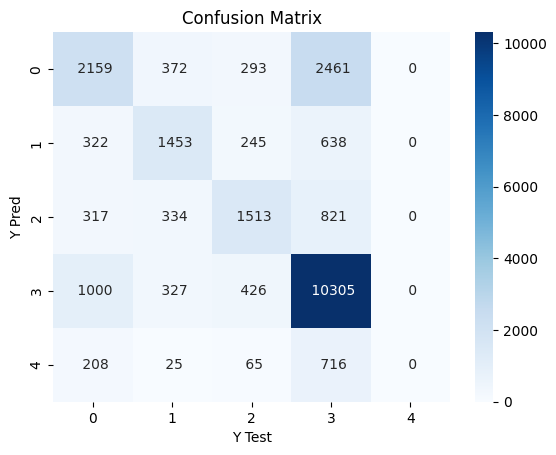

In [47]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
cm=confusion_matrix(ytest,y_pred_final)
ax=sns.heatmap(cm,cmap='Blues',annot=True,fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Y Test')
ax.set_ylabel('Y Pred')

#### modeling-tried but didn't get good accuracy

In [ ]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(xtrain_tfidf, ytrain)

predicted_naive = clf.predict(xtest_tfidf)

In [ ]:
# Metrics :) 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

print('Accuracy Score \n',accuracy_score(predicted_naive, ytest))
print('Confusion Matrix \n', confusion_matrix(predicted_naive, ytest))
print('Classification Report \n', classification_report(predicted_naive, ytest))

In [ ]:
# MLP classifier 
from sklearn.neural_network import MLPClassifier

mlp_cv=MLPClassifier(early_stopping=True, verbose=2)
mlp_cv.fit(xtrain_tfidf, ytrain)

In [ ]:
predicted_mlp = mlp_cv.predict(xtest_tfidf)

In [64]:
# Metrics :) 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

def metrics(predicted): 
    predicted_naive = predicted 
    print('Accuracy Score \n',accuracy_score(predicted_naive, ytest))
    print('Confusion Matrix \n', confusion_matrix(predicted_naive, ytest))
    print('Classification Report \n', classification_report(predicted_naive, ytest))

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain_tfidf, ytrain)
predictions = rf.predict(xtest_tfidf)
metrics(predictions)

Accuracy Score 
 0.5966666666666667
Confusion Matrix 
 [[ 1863   365   438   800   125]
 [  224  1057   313   159    15]
 [   67    71   378    78    12]
 [ 3131  1165  1856 11021   861]
 [    0     0     0     0     1]]
Classification Report 
               precision    recall  f1-score   support

           0       0.35      0.52      0.42      3591
           1       0.40      0.60      0.48      1768
           2       0.13      0.62      0.21       606
           3       0.91      0.61      0.73     18034
           4       0.00      1.00      0.00         1

    accuracy                           0.60     24000
   macro avg       0.36      0.67      0.37     24000
weighted avg       0.77      0.60      0.65     24000

